In [ ]:
import os
import re
from collections import Counter
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
from fa2 import ForceAtlas2

# Datasets retrieved from WoS and MAG
**Given the strict terms of use of WoS dataset, we are unable to share the dataset. Here shows the code for the analyses in the paper**
* data: Meta data downloaded from WoS
* extend: pair-wise matching of received citations from MAG
* biblic: pair-wise matching of references from MAG


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/wos.csv')
extend=pd.read_csv('/content/drive/My Drive/Colab Notebooks/citing2_year.csv')
wos=pd.read_csv('/content/drive/My Drive/Colab Notebooks/id_drop1.csv')
biblic=pd.read_csv('/content/drive/My Drive/Colab Notebooks/reference2.csv')

In [ ]:
#the most cited articles from WoS
data.sort_values(by=["Times_Cited"],ascending=False)[:1]

,Author,Times_Cited,Abstract,Title,Keywords,Date,Year,Journal,DOI,ISSN,References,Address,Categories
11591,"Marwick, AE; Boyd, D",1186,Social media technologies collapse multiple au...,"I tweet honestly, I tweet passionately: Twitte...",audience; context; identity; micro-celebrity; ...,FEB,2011.0,NEW MEDIA & SOCIETY,10.1177/1461444810365313,1461-4448,"Albertson B., 2006, DOG WHISTLE POLITICS; BANA...","[Marwick, Alice E.] NYU, Dept Media Culture & ...",Communication


In [ ]:
# MAG pair-wise matching data example
extend.head(3)

,DOI,ID,Title,citing,DOI_y,PaperTitle,Year
0,10.1016/j.is.2013.09.002,1965015069,Discovering OLAP dimensions in semi-structured...,1948438205,10.1186/s41039-015-0007-z,the utilization of data analysis techniques in...,2015.0
1,10.1016/j.is.2013.09.002,1965015069,Discovering OLAP dimensions in semi-structured...,2407118172,10.2991/icsste-16.2016.156,research on the structured data mining algorit...,2016.0
2,10.1016/j.is.2013.09.002,1965015069,Discovering OLAP dimensions in semi-structured...,2566800347,10.1145/3014812.3014863,generating cubes from smart city web data,2017.0


# Data preprocessing

In [ ]:
## preprocessing WoS data
# get reference doi from WoS meta data
data.DOI=data.DOI.str.lower()
for n in range(len(data)):
  ls=[]
  try:
    for i in data.References[n].strip().split('; '):
      for j in i.split(','):
        if 'DOI' in j:
          ls.append(j.replace('DOI','').replace('[','').replace(']','').lower().strip())
    data.loc[n,'cites_doi']='; '.join([i for i in set(ls)])
  except:
    data.loc[n,'cites_doi']=np.nan
# set DOIs to indexes 
article_=[i for i in data.DOI.str.lower()]
np_article=np.array(article_).reshape(-1,1)
index_doi=dict(enumerate(np_article[:,0])) 
doi_index=dict((j,i) for i,j in enumerate(np_article[:,0]))

In [ ]:
# extract direct citation relations from WoS
cite=data[['Title','DOI','Year','cites_doi']]
edges=[]
for i in range(len(cite)):
    try:
      a=cite.cites_doi[i].strip().split('; ')
      for k in range(len(a)):
        if a[k] not in 'nan':    
          edges.append((cite.DOI[i].lower(),a[k]))
    except:
        pass

In [ ]:
# within dataset citation from mag dataset
extend.DOI=extend.DOI.str.lower()
extend.DOI_y=extend.DOI_y.str.lower()
extend_citess=extend[['DOI','citing','DOI_y','Year']]
extend_citess.columns=['DOI','citing_ind','citing','Year']
extend_citess['Year']=[int(eval(str(i))) if str(i) not in 'nan' else i for i in extend_citess.Year]
mag=extend_citess[extend_citess.citing_ind.isin(wos.ID)].drop_duplicates().reset_index(drop=True)
#add doi
for i in range(len(mag)):
  mag.at[i,'citing']=wos[wos.ID==mag.loc[i,'citing_ind']].DOI.to_list()[0]

In [ ]:
# in mag not in wos
mnw=extend_citess[~extend_citess.citing_ind.isin(wos.ID)].drop_duplicates(subset=['DOI','citing_ind']).dropna(subset=['citing_ind','Year']).reset_index(drop=True)

# Co-citation and bibliographic coupling

In [ ]:
#within dataset citation wos
#@title within dataset co-citations
# the index is the same
citess=pd.DataFrame()
citess['DOI']=[i[1] for i in edges]
citess['citing']=[i[0] for i in edges]
cite.columns=['Title', 'citing', 'Year', 'cites_doi'] #add year to citess
citess=citess.merge(cite,on=['citing'],how='left')
w=citess[citess['DOI'].isin(data['DOI'])].reset_index(drop=True)

In [ ]:
#combine wos and mag
com=w.merge(mag,on=['DOI', 'citing'],how='outer')[['DOI','citing','citing_ind']].drop_duplicates() 
# combine with Year information
com['Year']=com.citing.apply(lambda x: data[data.DOI==x].Year.to_list()[0])
com_year=com.dropna(subset=['Year']).reset_index(drop=True)

In [ ]:
#get the index from the doi
com_year['cited_ind']=[doi_index[i] for i in com_year.DOI] 
mnw['cited_ind']=[doi_index[i] for i in mnw.DOI]

In [ ]:
len(mnw)+len(com_year)

189630

In [ ]:
#within set co-citation with year
#the combination of cited articles based on citing groups
co_ci=[]
for i in com_year.groupby('citing').cited_ind.groups:
  #return the index of the groupby object
  j=com_year[com_year['citing']==i].cited_ind.to_list()
  year=com_year[com_year.citing==i].Year.to_list()[0]
  if len(j)>1:
    co_ci=co_ci+([(n,str(year)) for n in combinations(j,2)])

In [ ]:
#sort by the value
co_ci=[(tuple(sorted(word[0])),word[1]) for word in co_ci]
#number of internal co-citation links
len(co_ci)

89670

In [ ]:
#@title bibliographic coupling
# the combination of citing based on the reference list 
from tqdm import tqdm
bc=citess[['citing','DOI']]
bibli_co=[]
for i in tqdm(bc.groupby('DOI').citing.unique()):
  if len(i)>1:
    bibli_co=bibli_co+([n for n in combinations(i,2)])

100%|██████████| 151701/151701 [13:46<00:00, 183.56it/s]


In [ ]:
#from mag
bibli_mag=[]
for i in tqdm(biblic.groupby('reference').DOI.unique()):
  if len(i)>1:
    bibli_mag=bibli_mag+([n for n in combinations(i,2)])

100%|██████████| 193725/193725 [20:47<00:00, 155.28it/s]


In [ ]:
# combine
bibli_co=[tuple(sorted(word)) for word in bibli_co]
bibli_mag=[tuple(sorted(word)) for word in bibli_mag]
df_co=pd.DataFrame(bibli_co,columns=['c1','c2'])
df_mag=pd.DataFrame(bibli_mag,columns=['c1','c2'])
merge=df_co[~df_co.set_index(['c1','c2']).index.isin(df_mag.set_index(['c1','c2']).index)].reset_index(drop=True)
merge=pd.concat([df_co,merge]).reset_index(drop=True)
merge['c1_ind']=[doi_index[i] for i in merge.c1] #from edges
merge['c2_ind']=[doi_index[i] for i in merge.c2] 

In [ ]:
#number of bibliographic coupling links
len(merge)

2876364

In [ ]:
#@title external co-citations
#only from mag
co_ci_extend=[]
for i in mnw.groupby('citing_ind').groups:
  j=mnw[mnw['citing_ind']==i].cited_ind.to_list()
  year=mnw[mnw.citing_ind==i].Year.to_list()[0]
  if len(j)>1:
    co_ci_extend=co_ci_extend+([(n,str(year)) for n in combinations(j,2)])
co_ci_extend=[(tuple(sorted(word[0])),word[1]) for word in co_ci_extend]

In [ ]:
#number of external co-citation links
len(co_ci_extend)

188950

# Network construction

In [ ]:
def df_to_list(df):
  return [(int(df.iloc[i].to_list()[0]),int(df.iloc[i].to_list()[1])) for i in range(len(df))]

In [ ]:
biblio_co=df_to_list(merge[['c1_ind','c2_ind']])

In [ ]:
co_ci=df_to_list(within)
co_ci_extend=df_to_list(full)

In [ ]:
# weighted bibliographic coupling network
count=dict(Counter(biblio_co))
edges_co=[(i+(count[i],)) for i in count]
G_bc=nx.Graph()
G_bc.add_weighted_edges_from(edges_co)

In [ ]:
# weighted internal co-citation network 
count=dict(Counter(co_ci))
edges_co=[(i+(count[i],)) for i in count]
G=nx.Graph()
G.add_weighted_edges_from(edges_co)

# weighted external co-citation network
count_1=dict(Counter(co_ci_extend+co_ci))
edges_co_1=[(i+(count_1[i],)) for i in count_1]
G_mag=nx.Graph()
G_mag.add_weighted_edges_from(edges_co_1)

# Network filtering

In [ ]:
# global filter 
def global_filter(G, n):
  # G: graph
  # n: link strength
  G_thr=G.copy()
  G_thr.remove_edges_from([e for e in G_thr.edges(data=True) if e[2]['weight'] < n])
  #remove the isolated nodes
  G_thr.remove_nodes_from([n for n in G_thr.nodes() if G_thr.degree(n) < 1])
  return G_thr


In [ ]:
# Disparity filter class 
class Disparity(object):
  
  # The implementation is based on the article:
  # "Extracting the multiscale backbone of complex weighted networks" M. Ángeles Serrano, Marián Boguña, Alessandro Vespignani https://arxiv.org/pdf/0904.2389.pdf
  # the sum of weights incident to the node

  def __init__(self, G):
    self.G=G
  # filter implementation
  def filter(self, a): 
      # probability density function
    def pdf(pij,k):
      return -(1-pij)**(k-1)-(-(1-0)**(k-1)) 
    #weights sum
    def s(G,i):
      neighbors = G.edges(i,data=True)
      return sum([node[2]['weight'] for node in neighbors]) 
  # normalize the weights
    def pij(G,i):
      ij=dict()
      k = len(G[i])
      if k > 1:
        for v in G[i]:
          w = G[i][v]['weight']
          p_ij = float(np.absolute(w))/s(G,i)
          ij[(i,v,w)]=p_ij
      return ij
    # filtered graph
    B=nx.Graph()
    for i in self.G.nodes():
      k=self.G.degree(i)
      if k>1:
        pi=pij(self.G,i)
        for edges in pi.keys():
          aij=pdf(pi[edges],k)
          if 1-aij <a:
            B.add_weighted_edges_from([edges])
    return B
  def f_n(self, B):
    return B.number_of_nodes()/self.G.number_of_nodes() #%Nt
  def f_e(self, B):
    return B.number_of_edges()/self.G.number_of_edges() #%Et
  def f_w(self, B):
    return sum([e[2]['weight'] for e in B.edges(data=True)])/sum([e[2]['weight'] for e in self.G.edges(data=True)])#%Wt
  def f_gcc(self, B): 
    def connected_component_subgraphs(G):
      for c in nx.connected_components(G):
          yield G.subgraph(c)                 # fraction of nodes in GCC
    GCC = max(connected_component_subgraphs(B),key=len)
    return GCC.number_of_nodes(), GCC.number_of_nodes()/B.number_of_nodes()


In [ ]:
# Results
# global filter
g_ls=[global_filter(G,i) for i in range(1,10)] #internal graph
g_ls_1=[global_filter(G_mag,i) for i in range(1,10)] #external graph
g_ls_2=[global_filter(G_bc,i) for i in range(1,10)] #bc graph

In [ ]:
# disparity filter
import decimal
z = [0.01]+[decimal.Decimal(i) / decimal.Decimal(10) for i in range(1, 10)] #alpha between 0.01-1
G_icc=Disparity(G) #internal graph
G_ecc=Disparity(G_mag) #external graph
G_bcn=Disparity(G_bc) # bc graph
d_ls=[G_icc.filter(i) for i in z]
d_ls_1=[G_ecc.filter(i) for i in z]
#d_ls_2=[G_bcn.filter(i) for i in z]
from tqdm import tqdm
d_ls_2=[]
for i in tqdm(z):
  d_ls_2.append(G_bcn.filter(i))

100%|██████████| 9/9 [2:30:43<00:00, 1004.84s/it]


In [ ]:
d_ls.append(G)
d_ls_1.append(G_mag)
d_ls_2.append(G_bc)

In [ ]:
# some network quantities
def f_n(i,ls):
  return ls[i].number_of_nodes()/ls[-1].number_of_nodes() #%Nt
def f_e(i,ls):
  return ls[i].number_of_edges()/ls[-1].number_of_edges() #%Et
def f_w(i,ls):
  return sum([e[2]['weight'] for e in ls[i].edges(data=True)])/sum([e[2]['weight'] for e in ls[-1].edges(data=True)])#%Wt
def f_gcc(G):                   # fraction of nodes in GCC
  GCC = max(connected_component_subgraphs(G),key=len)
  return GCC.number_of_nodes()/G.number_of_nodes()
def a_d(G):
  return sum([d for (n, d) in nx.degree(G)]) / float(G.number_of_nodes())


In [ ]:
icc_=[d_ls,g_ls]
ecc_=[d_ls_1,g_ls_1]
bc_=[d_ls_2,g_ls_2]
all=[icc_,ecc_,bc_]

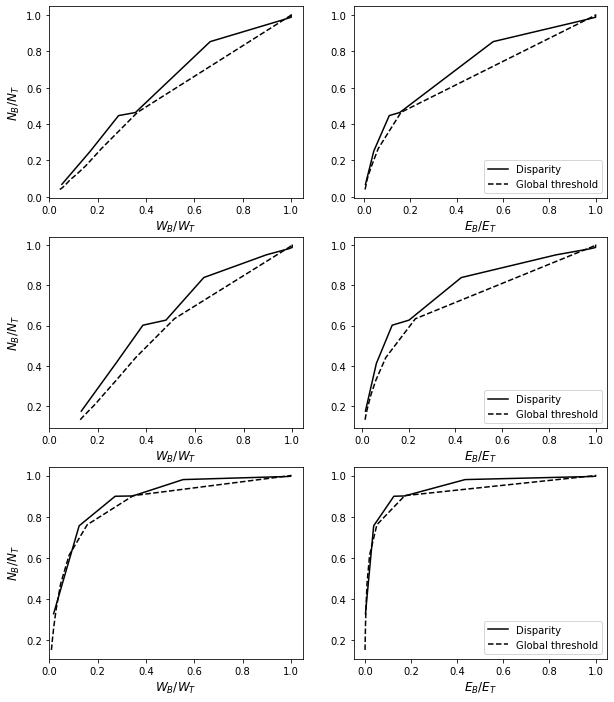

In [ ]:
# comparison between the two filters
#titles=['Internal co-citation network','External co-citation network','Bibliographic coupling network']
fig, ax = plt.subplots(3,2,figsize=(10,12))
for n,col in enumerate(ax):
  graph=all[n]
  d_x,d_x1,d_y=[],[],[]
  g_x,g_x1,g_y=[],[],[]
  for i in range(12):
    try:
      d_x.append(f_e(i,graph[0]))
      dx_1.append(f_w(i,graph[0]))
      d_y.append(f_n(i,graph[0]))
      g_x.append(f_e(i,graph[1]))
      gx_1.append(f_w(i,graph[1]))
      g_y.append(f_n(i,graph[1]))
    except:
      pass
  col[1].set_xlabel("$ E_{B}$/$E_{T} $", fontsize=12)
  col[0].set_ylabel("$ N_{B}$/$N_{T} $", fontsize=12)
  col[1].plot(sorted(d_x), sorted(d_y),label="Disparity",color='black')
  col[1].plot(sorted(g_x), sorted(g_y),'--',label="Global threshold",color='black')
  col[0].plot(sorted(dx_1), sorted(d_y),label="Disparity",color='black')
  col[0].plot(sorted(gx_1), sorted(g_y),'--',label="Global threshold",color='black')
  col[0].set_xlabel("$ W_{B}$/$W_{T} $", fontsize=12)
  col[1].legend(loc='lower right')
  col[0].set_xlim(0, )
  col[0].set_xlim(0, )
    


In [ ]:
# different level of reduction for disparity filter
#x: %E; y: ACC; y_1: %N; y_2: %w; y_3: average degree
x,y,y_1,y_2,y_3=[],[],[],[],[]
x_mag,y_mag,y_mag1,y_mag2,y_mag3=[],[],[],[],[]
x_bc,y_bc,y_bc1,y_bc2,y_bc3=[],[],[],[],[]
for i in range(len(d_ls)):
  try:
    y_bc.append(acc(d_ls_2[i]))
    y_bc2.append(f_w(i,d_ls_2))
    y_bc3.append(a_d(d_ls_2[i]))
    x_bc.append(f_e(i,d_ls_2))
    y_bc1.append(f_n(i,d_ls_2))
    
    y.append(acc(d_ls[i]))
    y_2.append(f_w(i,d_ls))
    y_3.append(a_d(d_ls))
    x.append(f_e(i,d_ls))
    y_1.append(f_n(i,d_ls))

    y_mag.append(acc(d_ls_1[i]))
    y_mag2.append(f_w(i,d_ls_1))
    y_mag3.append(a_d(d_ls_1))
    x_mag.append(f_e(i,d_ls_1))
    y_mag1.append(f_n(i,d_ls_1))

  except:
    pass

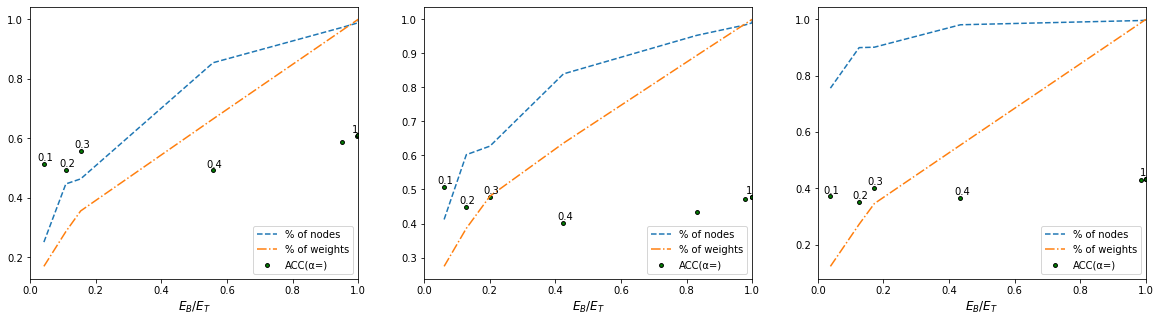

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ls_x=[x,x_mag,x_bc]
ls_y=[y,y_mag,y_bc]
ls_y1=[y_1,y_mag1,y_bc1]
ls_y2=[y_2,y_mag2,y_bc2]
ls_y3=[y_3,y_mag3,y_bc3]
for i,col in enumerate(ax):
    col.set_xlabel("$ E_{B}$/$E_{T} $", fontsize=12)
    col.set_xlim(0,1)
    col.plot(ls_x[i],ls_y1[i],'--',label="% of nodes")
    col.plot(ls_x[i],ls_y2[i],'-.',label="% of weights")
    col.scatter(ls_x[i],ls_y[i],label="ACC(α=)",edgecolors='black',c='green',s=15)
    label=['0.1','0.2','0.3','0.4']+['']*5+['1']
    for j, txt in enumerate(label):
      col.annotate(txt, (ls_x[i][j]-0.02, ls_y[i][j]+0.01),zorder=9)
    col.legend(loc='lower right')

plt.show()

In [ ]:
icc=d_ls[:3]+[d_ls[-1]]
ecc=d_ls_1[:3]+[d_ls_1[-1]]
bc=d_ls_2[:3]+[d_ls_2[-1]]
ls_bc=[icc,ecc,bc]

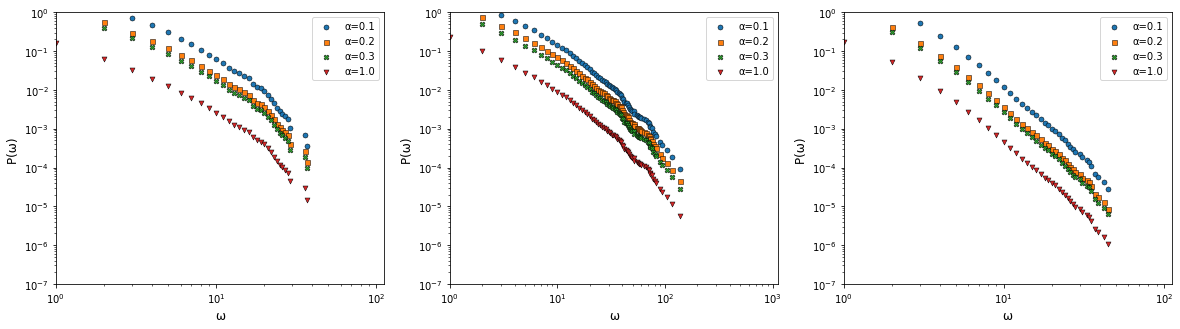

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
for n,col in enumerate(ax):
  ls_w=[]
  ls_c=[]
  for i,j in enumerate(ls_bc[n]):
    w, c = zip(*Counter([e[2]['weight'] for e in j.edges(data=True)]).items())
    ls_w.append(w)
    ls_c.append(c)
  label=['α=0.1','α=0.2','α=0.3','α=1.0']
  markers=['o','s','X','v']
  for i in range(4):
    p= pc(ls_w[i],ls_c[i])
    col.scatter([i for i,j in p],[j for i,j in p], label=str(label[i]),edgecolors='black',s=25,marker=markers[i],linewidths=0.5)
  col.set_xscale("log")
  col.set_yscale("log")
  col.set_xlim(1, )
  col.set_ylim(10e-8,1)
  col.set_xlabel("ω", fontsize=12)
  col.set_ylabel("P(ω) ", fontsize=12)
  col.legend(loc='upper right')
plt.show()

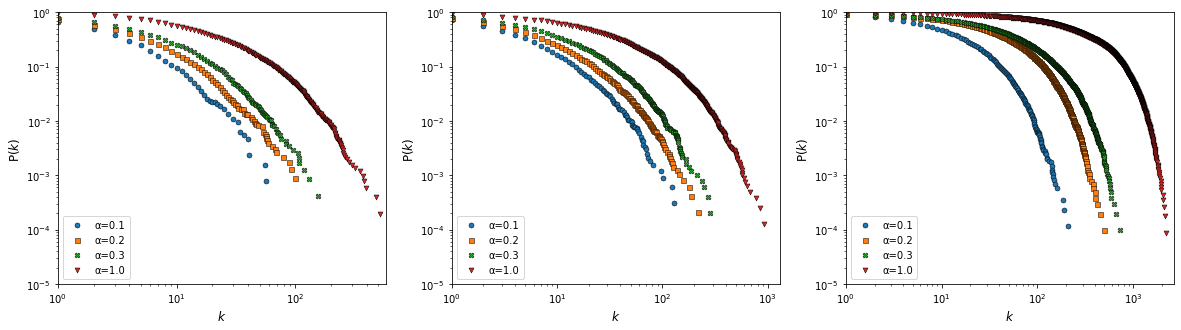

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
for n,col in enumerate(ax):
  ls_w=[]
  ls_c=[]
  for i,j in enumerate(ls_bc[n]):
    w, c =  zip(*Counter([d for n, d in j.degree()]).items())
    ls_w.append(w)
    ls_c.append(c)
  label=['α=0.1','α=0.2','α=0.3','α=1.0']
  markers=['o','s','X','v']
  for i in range(4):
    p= pc(ls_w[i],ls_c[i])
    col.scatter([i for i,j in p],[j for i,j in p], label=str(label[i]),edgecolors='black',s=25,marker=markers[i],linewidths=0.5)
  col.set_xscale("log")
  col.set_yscale("log")
  col.set_xlim(1, )
  col.set_ylim(10e-6,1)
  col.set_xlabel("$k$", fontsize=12)
  col.set_ylabel("P($k$) ", fontsize=12)
  col.legend(loc='lower left')
plt.show()

In [ ]:
icc=g_ls[2:4]+[d_ls[2]]+[g_ls[0]]
ecc=g_ls_1[2:4]+[d_ls_1[2]]+[g_ls_1[0]]
bc=g_ls_2[3:5]+[d_ls_2[0]]+[g_ls_2[0]]
ls_bc=[icc,ecc,bc]

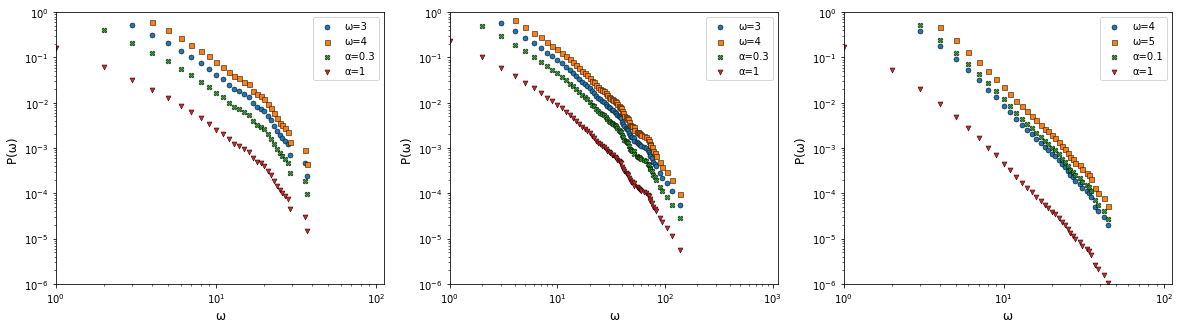

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
label=[['ω=3','ω=4','α=0.3','α=1'],['ω=3','ω=4','α=0.3','α=1'],['ω=4','ω=5','α=0.1','α=1']]
for n,col in enumerate(ax):
  ls_w=[]
  ls_c=[]
  for i,j in enumerate(ls_bc[n]):
    w, c = zip(*Counter([e[2]['weight'] for e in j.edges(data=True)]).items())
    ls_w.append(w)
    ls_c.append(c)
  markers=['o','s','X','v']
  for i in range(4):
    p= pc(ls_w[i],ls_c[i])
    col.scatter([i for i,j in p],[j for i,j in p], label=str(label[n][i]),edgecolors='black',s=25,marker=markers[i],linewidths=0.5)
  col.set_xscale("log")
  col.set_yscale("log")
  col.set_xlim(1, )
  col.set_ylim(10e-7,1)
  col.set_xlabel("ω", fontsize=12)
  col.set_ylabel("P(ω) ", fontsize=12)
  col.legend(loc='upper right')
plt.show()

In [ ]:
G_thr,G_thr1,G_thr2=d_ls[3],d_ls_1[3],d_ls_2[1]

In [ ]:
print(G_thr.number_of_nodes(), G_icc.f_n(G_thr), G_thr.number_of_edges(), G_icc.f_e(G_thr), G_icc.f_gcc(G_thr),a_d(G_thr))

2355 0.46385660823320857 10448 0.15413439551523198 (2201, 0.9346072186836518) 8.873036093418259


In [ ]:
print(G_thr1.number_of_nodes(), G_ecc.f_n(G_thr1), G_thr1.number_of_edges(), G_ecc.f_e(G_thr1), G_ecc.f_gcc(G_thr1),a_d(G_thr1))

5030 0.627416739428714 35267 0.20107759849478304 (4861, 0.9664015904572565) 14.022664015904573


In [ ]:
print(G_thr2.number_of_nodes(), G_bcn.f_n(G_thr2), G_thr2.number_of_edges(), G_bcn.f_e(G_thr2), G_bcn.f_gcc(G_thr2),a_d(G_thr2))

9192 0.8053267916593657 81746 0.04369527800643568 (8989, 0.9779155787641427) 17.786335944299392


# Community detection

In [ ]:
  !pip install infomap
  import infomap

In [ ]:
import networkx.algorithms.community as nx_comm
from collections import defaultdict
# calculate modularity
def modularity(G, communities):
  v = defaultdict(list)
  for key, value in sorted(dict(communities).items()):
      v[value].append(key)
  return nx_comm.modularity(G, v.values())
#run infomap on weighted graph
def commu_detect_weighted(G):
  im = infomap.Infomap()
  links=[(i,j,float(k['weight'])) for i,j,k in list(G.edges(data=True))]
  im.add_links(links)
  im.run()
  communities = im.get_modules()
  n= im.num_top_modules
  m=modularity(G, communities)
  nx.set_node_attributes(G,communities,'community')
  return (n, m),G
def commu_detect(G):
  im = infomap.Infomap()
  links=[(i,j) for i,j in list(G.edges())]
  im.add_links(links)
  im.run()
  communities = im.get_modules()
  n= im.num_top_modules
  m=modularity(G, communities)
  nx.set_node_attributes(G,communities,'community')
  return (n, m),G


In [ ]:
print('weighted:', commu_detect_weighted(G)[0], 'unweighted:', commu_detect(G)[0])

weighted: (64, 0.6170813722001244) unweighted: (64, 0.6153118294086174)


In [ ]:
print('weighted:', commu_detect_weighted(G_mag)[0], 'unweighted:', commu_detect(G_mag)[0])

weighted: (75, 0.5362677460476727) unweighted: (249, 0.651994443485378)


In [ ]:
print('weighted:', commu_detect_weighted(G_bc)[0], 'unweighted:', commu_detect(G_bc)[0])

weighted: (386, 0.6206218516671737) unweighted: (333, 0.6294424947454634)


In [ ]:
y=[commu_detect_weighted(i)[0][1] for i in [G_mag, G, G_bc]]
y1=[commu_detect(i)[0][1] for i in [G_mag,G,  G_bc]]
x=['ECC','ICC','BC']


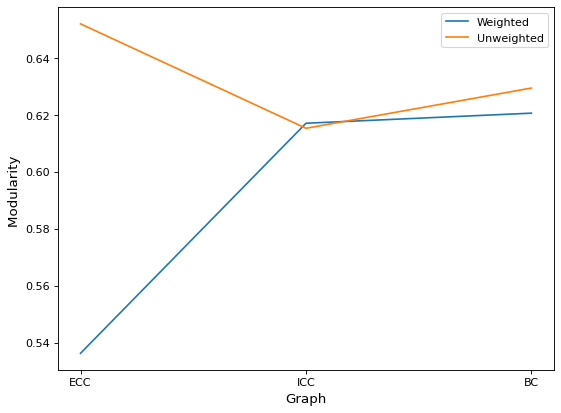

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(x,y,label='Weighted')
plt.plot(x,y1,label='Unweighted')
plt.legend()
plt.xlabel("Graph", fontsize=12)
plt.ylabel("Modularity ", fontsize=12); 

In [ ]:
# save networks to drive
fh = open("G3.edgelist", "w")
nx.write_edgelist(G, "G3.edgelist")
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp G3.edgelist "/content/drive/My Drive/Colab Notebooks/"

# Dynamic network/cumulative network 

In [ ]:
# the links saved from within set and extended edges
within=pd.read_csv("/content/drive/My Drive/Colab Notebooks/within_co_ci.csv")
full=pd.read_csv("/content/drive/My Drive/Colab Notebooks/full_co_ci.csv")

In [ ]:
#set year range
within['Year_range']=[np.ceil((i-2004)/5) if i <2019 else 3.0 for i in within.Year]
full['Year_range']=[np.ceil((i-2004)/5) if i <2019 else 3.0 for i in full.Year]

In [ ]:
# for external co-citation
edges=pd.concat([within,full]).reset_index(drop=True)

In [ ]:
# dynamic
edges_df_1=edges[edges.Year_range==1.0].reset_index(drop=True)
edges_df_2=edges[edges.Year_range.isin([2.0 ])].reset_index(drop=True)
edges_df_3=edges[edges.Year_range.isin([3.0])].reset_index(drop=True)

# cumulative
edges_df_1=edges[edges.Year_range==1.0].reset_index(drop=True)
edges_df_2=edges[edges.Year_range.isin([1.0, 2.0 ])].reset_index(drop=True)
edges_df_3=edges

In [ ]:
edges_list_1=df_to_list(edges_df_1)
edges_list_2=df_to_list(edges_df_2)
edges_list_3=df_to_list(edges_df_3)

In [ ]:
def weighted_networks(list):
  count=dict(Counter(list))
  edges_co=[(i+(count[i],)) for i in count]
  G=nx.Graph()
  G.add_weighted_edges_from(edges_co)
  return G

In [ ]:
G1=weighted_networks(edges_list_1)
G2=weighted_networks(edges_list_2)
G3=weighted_networks(edges_list_3)

In [ ]:
def community(edges_list):
  G=nx.Graph()
  G.add_edges_from([i for i in edges_list])
  im = infomap.Infomap()
  im.add_links(G.edges())
  im.run()
  communities = im.get_modules()
  nx.set_node_attributes(G, communities, 'community')
  print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")
  return G,communities

In [ ]:
links=[(int(i),int(j)) for i,j in G1.edges()]
G1,communities=community(links)

Found 8 modules with codelength: 4.228097616925863


In [ ]:
links=[(int(i),int(j)) for i,j in G2.edges()]
G2,communities=community(links)

Found 69 modules with codelength: 8.54438186800827


In [ ]:
links=[(int(i),int(j)) for i,j in G3.edges()]
G3,communities=community(links)

Found 233 modules with codelength: 11.076134093613076
